In [747]:
# first import all necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

In [748]:
# read the training / test data 
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [749]:
# look through the features to get a good general overview about what data to expect 
training.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [750]:
# have a closer look at the dimensions and types of features 
print(training.shape)
training.info()

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


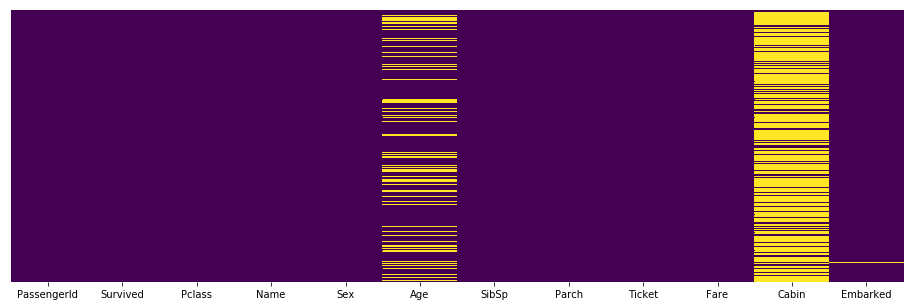

In [751]:
# we can see that the number of age and cabin entries seem to differ largely from the other features and the embarked feature has 2 missing values
# lets visualize the missing values in order to understand if there is a pattern to the absence of data
plt.figure(figsize = (16,5))
sns.heatmap(training.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [752]:
# we calculate the percentage of missing values for the two predominant features
def per_nan(df, cols):
    '''calculates the percentage of missing values for provided columns (cols) in a df'''
    for col in cols:
        percentage = (df[col].isnull().sum() / len(df[col])) * 100
        print('Percent of missing values in {0}: {1:.3}%'.format(col, percentage))
    return

per_nan(training, ['Age', 'Cabin'])

Percent of missing values in Age: 19.9%
Percent of missing values in Cabin: 77.1%


In [753]:
# as predicted a lot of values (77.1%) are missing in the cabin feature up to a point where imputing the values is not reasonable.
# we will drop the feature as a result, together with the identifiers (PassengerId, Name) and the Ticket feature (probably useless, way too many values)
training = training.drop(['Cabin', 'Name', 'Ticket'], axis=1)
test = test.drop(['Cabin', 'Name', 'Ticket'], axis=1)

In [754]:
# the missing values in Age and Embarked feature can be imputed using the Sex/PClass features 
table = pd.pivot_table(training, values='Age', index=['Pclass', 'Sex'], aggfunc=np.nanmean)
table.head()

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000

In [755]:
# just to make sure we add an additional df where the nan's are deleted prior to calculation 
# however the difference is marginal
testing = training.dropna()
table = pd.pivot_table(testing, values='Age', index=['Pclass', 'Sex'], aggfunc=np.mean)
table.Age = table.Age.astype('int')
del testing
table.head()

Age
Pclass Sex        
1      female   34
       male     41
2      female   28
       male     30
3      female   21

In [756]:
# now we 
def impute_age(df):
    testing = df.dropna()
    table = pd.pivot_table(df, values='Age', index=['Pclass', 'Sex'], aggfunc=np.mean)
    table.Age = table.Age.astype('int')
    df[['Pclass','Sex','Age']] = df.set_index(['Pclass','Sex']).Age.fillna(table.Age).reset_index()
    df.Age = df.Age.astype('int')
    return df

training = impute_age(training)
test = impute_age(test)
training.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22,1,0,7.2500,S
1,2,1,1,female,38,1,0,71.2833,C
2,3,1,3,female,26,0,0,7.9250,S
3,4,1,1,female,35,1,0,53.1000,S
4,5,0,3,male,35,0,0,8.0500,S


In [757]:
# the categorical features are now transformed using one hot encoding.
#for item, col in zip([training, test], ['Fare']):
#training['Fare'] = pd.qcut(x=training['Fare'],  q=10, labels=range(10))
training = pd.get_dummies(training, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True)
#test['Fare'] = pd.qcut(x=test['Fare'],  q=10, labels=range(10))
test = pd.get_dummies(test, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True)

In [758]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Age            418 non-null int32
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Pclass_2       418 non-null uint8
Pclass_3       418 non-null uint8
Sex_male       418 non-null uint8
Embarked_Q     418 non-null uint8
Embarked_S     418 non-null uint8
dtypes: float64(1), int32(1), int64(3), uint8(5)
memory usage: 16.8 KB


In [759]:
# test Fare has one missing value 
test.Fare = test.Fare.fillna(0)

In [760]:
def split_into_xy(df):
    y = df['Survived']
    x = df.drop('Survived', axis=1)
    return (x,y)

x,y = split_into_xy(training)

## Modeling

In [761]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=291)

In [762]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
#clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [763]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.89      0.84       160
          1       0.80      0.65      0.72       108

avg / total       0.80      0.79      0.79       268



In [764]:
from sklearn.metrics import accuracy_score
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.48%


In [765]:
#clf.fit(x,y)
test['Survived'] = clf.predict(test)
#test['Survival'] = test.Survived.astype('object')

df_submit = test[['PassengerId', 'Survived']]


In [766]:
df_submit.shape

(418, 2)

In [767]:
import pathlib
import datetime
filename  = datetime.datetime.now().strftime('%y%m%d') + '_submission.csv'
filefolder = './submissions/'
submission = pathlib.Path(filefolder+filename)
if submission.is_file():
    filename  = datetime.datetime.now().strftime('%y%m%d_%H%M_') + '_submission.csv'
    df_submit.to_csv(filefolder + filename, header=['PassengerId', 'Survived'], index=False)
    
else:
    df_submit.to_csv(filefolder + filename, header=['PassengerId', 'Survived'], index=False)